In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import seaborn as sb
%matplotlib inline

# Analysis

In [2]:
# Prepare data
demographic = pd.read_csv('../data/processed/demographic.csv')
severity = pd.read_csv('../data/processed/severity.csv', index_col=0)
features = demographic.columns 
X = demographic.astype(np.float64)
y = (severity >= 4).sum(axis=1)

In [3]:
needs_to_label = {0:'no needs', 1:'low_needs', 2:'moderate needs', 3:'high needs', 4:'very high needs'}
labels = ["no needs", "low needs", "moderate needs", "high needs", "very high needs"]
severity_to_needs = {0:0, 1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:4, 8:4}
y = np.array([severity_to_needs[i] for i in y])
# Color vector, for illustration purposes
colors = {0:'b', 1:'r', 2:'g', 3:'c', 4:'y'}
y_c = np.array([colors[i] for i in y])

In [9]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    
    from sklearn.utils.multiclass import unique_labels

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=(14,7))
    ax.grid(False)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

### Class Balance

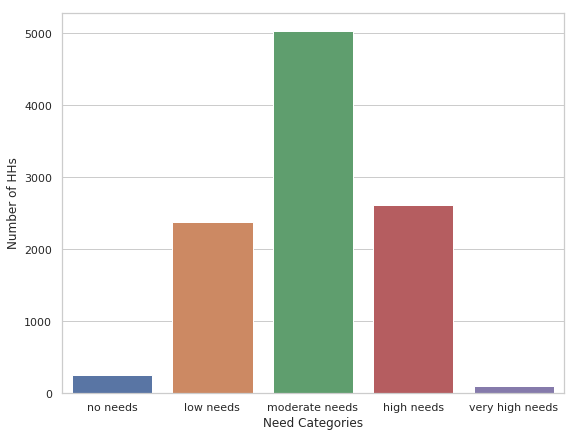

In [10]:
categories, counts = np.unique(y, return_counts=True)
fig, ax = plt.subplots(figsize=(9, 7))
sb.set(style="whitegrid")
sb.barplot(labels, counts, ax=ax, tick_label=labels)
ax.set(xlabel='Need Categories',
       ylabel='Number of HHs');

Heavy class imbalances. Use appropriate scoring metrics/measures.

In [11]:
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import balanced_accuracy_score

/home/muhadriy/.conda/envs/ml/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)

In [13]:
print('Training target statistics: {}'.format(Counter(y_train)))
print('Testing target statistics: {}'.format(Counter(y_test)))

Training target statistics: Counter({2: 4025, 3: 2094, 1: 1900, 0: 202, 4: 81})
Testing target statistics: Counter({2: 1007, 3: 523, 1: 475, 0: 51, 4: 20})


# GMM

In [14]:
from sklearn.mixture import GaussianMixture
from sklearn.utils import compute_class_weight

In [15]:
n_classes = len(np.unique(y_train))

In [16]:
gmm = GaussianMixture(n_components=n_classes, covariance_type='tied', n_init=10,
                      random_state=0, verbose=0)

In [17]:
gmm.means_init = np.array([X_train[y_train == i].mean(axis=0)
                                    for i in range(n_classes)])

In [18]:
gmm.fit(X_train)

GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=100,
                means_init=array([[1.88118812e-01, 5.79207921e-01, 2.32673267e-01, 4.45544554e-02,
        3.96039604e-02, 2.47524752e-02, 6.43564356e-02, 9.90099010e-02,
        7.42574257e-02, 3.46534653e-02, 8.91089109e-02, 3.71287129e-01,
        1.58415842e-01, 1.18811881e-01, 6.63366337e-01, 2.17821782e-01,
        3.01980198e-01, 6.9...
        5.67901235e-01, 1.23456790e-02, 1.72839506e-01, 7.77777778e-01,
        3.99012346e+01, 4.33580247e+01, 1.85185185e-01, 0.00000000e+00,
        7.06172840e+00, 1.48148148e-01, 0.00000000e+00, 4.69135802e-01,
        2.90123457e+00, 2.76543210e+00, 1.24691358e+00]]),
                n_components=5, n_init=10, precisions_init=None, random_state=0,
                reg_covar=1e-06, tol=0.001, verbose=0, verbose_interval=10,
                warm_start=False, weights_init=None)

In [19]:
y_pred = gmm.predict(X_test)

GMM performance:
Balanced accuracy: 0.32 - Geometric mean 0.30
Confusion matrix, without normalization


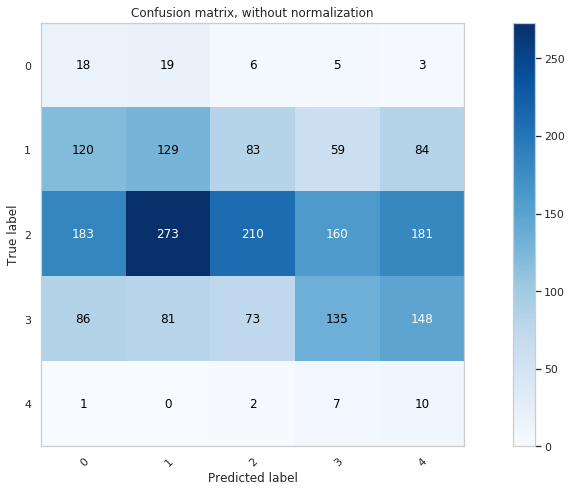

In [20]:
print('GMM performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred),
              geometric_mean_score(y_test, y_pred)))

plot_confusion_matrix(y_test, y_pred, classes=np.unique(y))

# Bayesian GMM

In [72]:
from sklearn.mixture import BayesianGaussianMixture

In [73]:
n_classes = len(np.unique(y_train))

In [74]:
bgmm = BayesianGaussianMixture(n_components=5, covariance_type='tied',
                      random_state=0, verbose=0, n_init=10)

In [75]:
bgmm.fit(X_train)

BayesianGaussianMixture(covariance_prior=None, covariance_type='tied',
                        degrees_of_freedom_prior=None, init_params='kmeans',
                        max_iter=100, mean_precision_prior=None,
                        mean_prior=None, n_components=5, n_init=10,
                        random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
                        verbose_interval=10, warm_start=False,
                        weight_concentration_prior=None,
                        weight_concentration_prior_type='dirichlet_process')

In [78]:
y_pred = bgmm.predict(X_test)

Bayesian GMM performance:
Balanced accuracy: 0.24 - Geometric mean 0.11
Confusion matrix, without normalization
[[ 23  26   0   1   1]
 [120 292  31  15  17]
 [226 636  62  33  50]
 [130 325  29  12  27]
 [  2  14   3   0   1]]


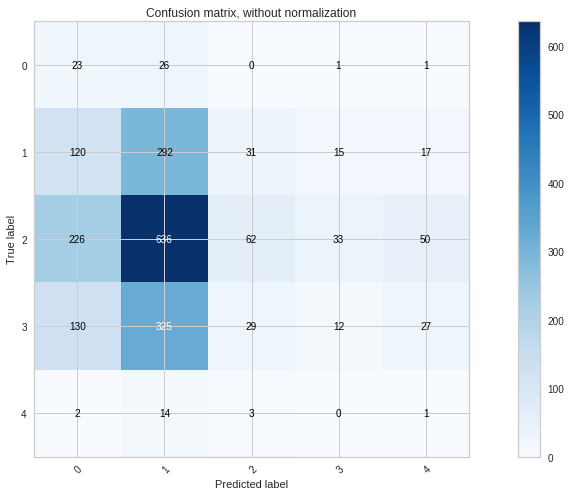

In [79]:
print('Bayesian GMM performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred),
              geometric_mean_score(y_test, y_pred)))

plot_confusion_matrix(y_test, y_pred, classes=np.unique(y))